In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval


### Reading transactions data

In [4]:
df_transactions = pd.read_csv('data/transactions_train.csv')
df_transactions

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2
...,...,...,...,...,...
31788319,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,929511001,0.059305,2
31788320,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,891322004,0.042356,2
31788321,2020-09-22,fff380805474b287b05cb2a7507b9a013482f7dd0bce0e...,918325001,0.043203,1
31788322,2020-09-22,fff4d3a8b1f3b60af93e78c30a7cb4cf75edaf2590d3e5...,833459002,0.006763,1


### Grouping data by date and customer_id to find items that were bought together at the same purchase 

In [5]:
g = df_transactions.groupby(['t_dat','customer_id'])['article_id'].apply(lambda x : list(int(item) for item in x)) #.iloc[:50]
df = pd.DataFrame(g)
df.rename(mapper={'article_id':'Bought_together'}, axis=1, inplace=True)
df

Bought_together
t_dat      customer_id                                                                                          
2018-09-20 000058a12d5b43e67d225668fa1f8d618c13dc232df0cad...                             [663713001, 541518023]
           00007d2de826758b65a93dd24ce629ed66842531df66993...  [505221004, 685687003, 685687004, 685687001, 5...
           00083cda041544b2fbb0e0d2905ad17da7cf1007526fb4c...  [688873012, 501323011, 598859003, 688873020, 6...
           0008968c0d451dbc5a9968da03196fe20051965edde7413...                             [531310002, 529841001]
           000aa7f0dc06cd7174389e76c9e132a67860c5f65f97069...  [501820043, 501820043, 674681001, 671505001, 6...
...                                                                                                          ...
2020-09-22 ffd4cf2217de4a0a3f9f610cdec334c803692a18af08ac5...  [896169005, 791587021, 791587021, 910949002, 7...
           fff2282977442e327b45d8c89afde25617d00124d0f9998...                             [929511001, 891322004]
           fff380805474b287b05cb2a7507b9a013482f7dd0bce0e6...                                        [918325001]
           fff4d3a8b1f3b60af93e78c30a7cb4cf75edaf2590d3e59...                                        [833459002]
           fffef3b6b73545df065b521e19f64bf6fe93bfd450ab20e...                                        [898573003]

[9080179 rows x 1 columns]

### Counting how many items were purchased together

In [6]:
df['Count'] = df['Bought_together'].apply(lambda x : len(x))
df['Count'].describe()

count    9.080179e+06
mean     3.500848e+00
std      3.619618e+00
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      4.000000e+00
max      5.700000e+02
Name: Count, dtype: float64

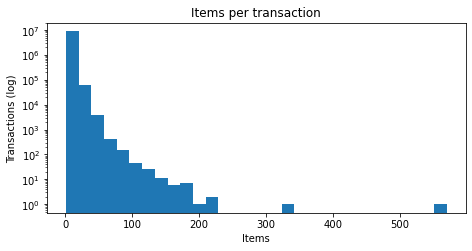

In [7]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.title('Items per transaction')
plt.xlabel('Items')
plt.ylabel('Transactions (log)')
plt.rcParams["figure.autolayout"] = True
k = df['Count']
x, bins, p = plt.hist(k,  log=True, bins = 30) 

### We are itrested in transactions with more than one item

In [8]:
df = df[df['Count']>1].copy()
df['Count'].describe()

count    6.393136e+06
mean     4.551957e+00
std      3.856783e+00
min      2.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      5.000000e+00
max      5.700000e+02
Name: Count, dtype: float64

### The code below creates the pairs of items and counts how many times each pair was purchased. It is very time-consuming, thus the output is saved as a csv file. 


In [9]:
df['Bought_together_sorted'] = df['Bought_together'].apply(lambda x : sorted(x))
df['Bought_together_sorted_list'] = df['Bought_together_sorted'].apply(lambda x: [[a, b] for idx, a in enumerate(x) for b in x[idx + 1:]])
df = df.explode('Bought_together_sorted_list')
df['Count_pairs'] = 1
df = df[['Bought_together_sorted_list','Count_pairs']]
df = df.assign(Bought_together_sorted_list=df['Bought_together_sorted_list'].astype(str)).groupby('Bought_together_sorted_list').sum()
df.to_csv('tmp.csv')

### Reading the output from previous block of code

In [10]:
df = pd.read_csv('tmp.csv', converters={'Bought_together_sorted_list': literal_eval})

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42451196 entries, 0 to 42451195
Data columns (total 2 columns):
 #   Column                       Dtype 
---  ------                       ----- 
 0   Bought_together_sorted_list  object
 1   Count_pairs                  int64 
dtypes: int64(1), object(1)
memory usage: 647.8+ MB


In [12]:
df = df.sort_values('Count_pairs', ascending = False)

In [13]:
df.head(30)

,Bought_together_sorted_list,Count_pairs
22177945,"[678342001, 678342001]",165091
16777178,"[629420001, 629420001]",21458
5349392,"[507909001, 507909001]",19946
14437791,"[610776002, 610776002]",13076
9175768,"[561445005, 561445005]",12998
159869,"[156231001, 156231001]",11924
26901467,"[706016001, 706016001]",11518
23707452,"[685816002, 685816002]",10887
23265413,"[684209013, 688537011]",10864
23698975,"[685816001, 685816001]",10205


### Checking if the pair is of the same or different items

In [14]:
df['same_item'] = df['Bought_together_sorted_list'].apply(lambda x: 1 if x[0] == x[1] else 0)

### Ploting the distribution of the number of times each pair was purchased 

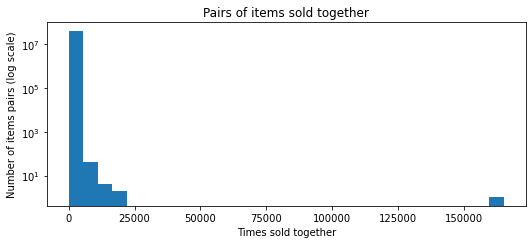

In [15]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.title('Pairs of items sold together')
plt.ylabel('Number of items pairs (log scale)')
plt.xlabel('Times sold together')
k = df['Count_pairs']
x, bins, p = plt.hist(k, log=True, bins=30) 

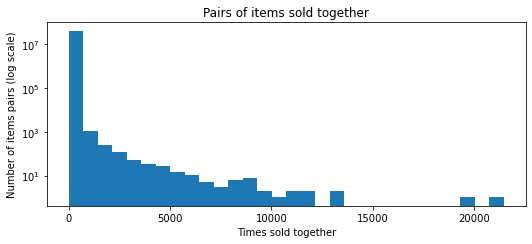

In [16]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.title('Pairs of items sold together')
plt.ylabel('Number of items pairs (log scale)')
plt.xlabel('Times sold together')
k = df['Count_pairs'].iloc[1:]
x, bins, p = plt.hist(k, log=True, bins=30) 

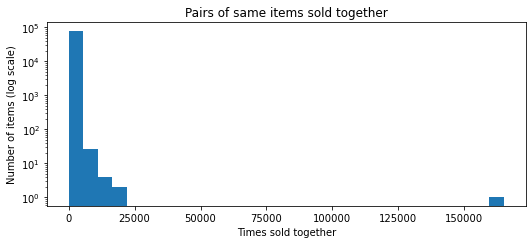

In [17]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.title('Pairs of same items sold together')
plt.ylabel('Number of items (log scale)')
plt.xlabel('Times sold together')
k = df[df['same_item']==1]['Count_pairs']
x, bins, p = plt.hist(k, log=True, bins=30) 

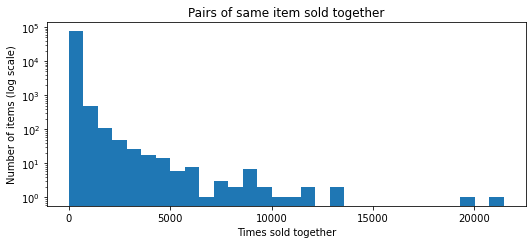

In [18]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.title('Pairs of same item sold together')
plt.ylabel('Number of items (log scale)')
plt.xlabel('Times sold together')
k = df[df['same_item']==1]['Count_pairs'].iloc[1:]
x, bins, p = plt.hist(k, log=True, bins=30) 

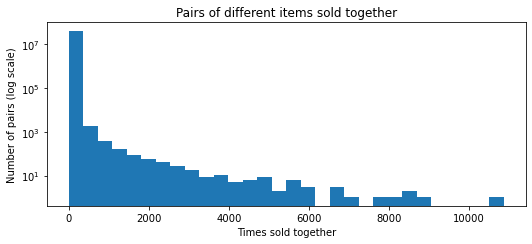

In [19]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.title('Pairs of different items sold together')
plt.ylabel('Number of pairs (log scale)')
plt.xlabel('Times sold together')
k = df[df['same_item']==0]['Count_pairs']
x, bins, p = plt.hist(k, log=True, bins=30) 

### Pairs that have been purchased more than 500 times together

In [20]:
df[df['Count_pairs']>500].describe()

,Count_pairs,same_item
count,2779.000000,2779.000000
mean,1267.411659,0.428212
std,3378.090914,0.494909
min,501.000000,0.000000
25%,599.000000,0.000000
50%,792.000000,0.000000
75%,1246.000000,1.000000
max,165091.000000,1.000000


### Counting pairs that have been only once purchased 

In [21]:
df[(df['Count_pairs']<2)]['Count_pairs'].describe()

count    27226803.0
mean            1.0
std             0.0
min             1.0
25%             1.0
50%             1.0
75%             1.0
max             1.0
Name: Count_pairs, dtype: float64

### Counting how many different items have been purchased together with others

In [22]:
df_exploded = df.explode('Bought_together_sorted_list')
df_exploded['Bought_together_sorted_list'].unique().size

104111

### Reading the data with the information about the items

In [23]:
df_articles = pd.read_csv('data/articles.csv')
df_articles

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105537,953450001,953450,5pk regular Placement1,302,Socks,Socks & Tights,1010014,Placement print,9,Black,...,Socks Bin,F,Menswear,3,Menswear,26,Men Underwear,1021,Socks and Tights,Socks in a fine-knit cotton blend with a small...
105538,953763001,953763,SPORT Malaga tank,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey,A,Ladieswear,1,Ladieswear,2,H&M+,1005,Jersey Fancy,Loose-fitting sports vest top in ribbed fast-d...
105539,956217002,956217,Cartwheel dress,265,Dress,Garment Full body,1010016,Solid,9,Black,...,Jersey,A,Ladieswear,1,Ladieswear,18,Womens Trend,1005,Jersey Fancy,"Short, A-line dress in jersey with a round nec..."
105540,957375001,957375,CLAIRE HAIR CLAW,72,Hair clip,Accessories,1010016,Solid,9,Black,...,Small Accessories,D,Divided,2,Divided,52,Divided Accessories,1019,Accessories,Large plastic hair claw.


In [24]:
df_articles.isna().sum()

article_id                        0
product_code                      0
prod_name                         0
product_type_no                   0
product_type_name                 0
product_group_name                0
graphical_appearance_no           0
graphical_appearance_name         0
colour_group_code                 0
colour_group_name                 0
perceived_colour_value_id         0
perceived_colour_value_name       0
perceived_colour_master_id        0
perceived_colour_master_name      0
department_no                     0
department_name                   0
index_code                        0
index_name                        0
index_group_no                    0
index_group_name                  0
section_no                        0
section_name                      0
garment_group_no                  0
garment_group_name                0
detail_desc                     416
dtype: int64

### Make sure there are no duplicates

In [25]:
df_articles['article_id'][df_articles['article_id'].duplicated()]

Series([], Name: article_id, dtype: int64)

### Creating top and bottom pairs to find in which categories the items belong to

In [26]:
top_pairs = df[(df['same_item']==0)].head(1000).copy()
top_pairs.head(10)

,Bought_together_sorted_list,Count_pairs,same_item
23265413,"[684209013, 688537011]",10864,0
24357396,"[689109001, 692930001]",8701,0
24360788,"[689109003, 692930003]",8454,0
26901468,"[706016001, 706016002]",8341,0
4947705,"[501616007, 507909001]",8224,0
14417374,"[610776001, 610776002]",7879,0
10806088,"[572797001, 572797002]",7060,0
23245920,"[684209004, 688537004]",6776,0
188302,"[160442007, 160442010]",6693,0
1593944,"[351484002, 723529001]",6666,0


In [27]:
bottom_pairs = df[(df['same_item']==0)].tail(1000).copy()

In [28]:
top_items = df[(df['same_item']==1)].head(1000).copy()
top_items.head(10)

,Bought_together_sorted_list,Count_pairs,same_item
22177945,"[678342001, 678342001]",165091,1
16777178,"[629420001, 629420001]",21458,1
5349392,"[507909001, 507909001]",19946,1
14437791,"[610776002, 610776002]",13076,1
9175768,"[561445005, 561445005]",12998,1
159869,"[156231001, 156231001]",11924,1
26901467,"[706016001, 706016001]",11518,1
23707452,"[685816002, 685816002]",10887,1
23698975,"[685816001, 685816001]",10205,1
14417373,"[610776001, 610776001]",9963,1


In [29]:
bottom_items = df[(df['same_item']==1)].tail(1000).copy()

In [30]:
top_pairs['first_item'] = top_pairs['Bought_together_sorted_list'].apply(lambda x: x[0])
top_pairs['second_item'] = top_pairs['Bought_together_sorted_list'].apply(lambda x: x[1])
top_pairs['first_item_type'] = top_pairs['first_item'].apply(lambda x: df_articles[df_articles['article_id']==x]['product_type_name'].values[0])
top_pairs['second_item_type'] = top_pairs['second_item'].apply(lambda x: df_articles[df_articles['article_id']==x]['product_type_name'].values[0])
top_pairs[['first_item_type', 'second_item_type','same_item']].groupby(['first_item_type', 'second_item_type']).count().sort_values(by='same_item',ascending=False).head(20)

,,same_item
first_item_type,second_item_type,
Bikini top,Swimwear bottom,291
Swimwear bottom,Bikini top,148
Trousers,Trousers,129
T-shirt,T-shirt,73
Vest top,Vest top,49
Swimwear bottom,Swimwear bottom,34
Bikini top,Bikini top,29
Shorts,Shorts,17
Underwear bottom,Underwear bottom,16


In [31]:
bottom_pairs['first_item'] = bottom_pairs['Bought_together_sorted_list'].apply(lambda x: x[0])
bottom_pairs['second_item'] = bottom_pairs['Bought_together_sorted_list'].apply(lambda x: x[1])
bottom_pairs['first_item_type'] = bottom_pairs['first_item'].apply(lambda x: df_articles[df_articles['article_id']==x]['product_type_name'].values[0])
bottom_pairs['second_item_type'] = bottom_pairs['second_item'].apply(lambda x: df_articles[df_articles['article_id']==x]['product_type_name'].values[0])
bottom_pairs[['first_item_type', 'second_item_type','same_item']].groupby(['first_item_type', 'second_item_type']).count().sort_values(by='same_item',ascending=False)

same_item
first_item_type second_item_type           
Flip flop       Dress                   109
                Trousers                 64
                Vest top                 40
                Blouse                   37
                Shorts                   32
...                                     ...
Necklace        Underwear bottom          1
Wedge           Bag                       1
                Ballerinas                1
                Belt                      1
Necklace        Garment Set               1

[125 rows x 1 columns]

In [32]:
top_items['item'] = top_items['Bought_together_sorted_list'].apply(lambda x: x[0])
top_items['item_type'] = top_items['item'].apply(lambda x: df_articles[df_articles['article_id']==x]['product_type_name'].values[0])
top_items[['item_type','same_item']].groupby(['item_type']).count().sort_values(by='same_item',ascending=False)

,same_item
item_type,
Trousers,188
T-shirt,136
Bikini top,104
Swimwear bottom,99
Vest top,61
Underwear bottom,42
Leggings/Tights,39
Dress,35
Shirt,33


In [33]:
bottom_items['item'] = bottom_items['Bought_together_sorted_list'].apply(lambda x: x[0])
bottom_items['item_type'] = bottom_items['item'].apply(lambda x: df_articles[df_articles['article_id']==x]['product_type_name'].values[0])
bottom_items[['item_type','same_item']].groupby(['item_type']).count().sort_values(by='same_item',ascending=False)

,same_item
item_type,
Trousers,102
Sweater,93
T-shirt,74
Dress,74
Jacket,47
...,...
Flip flop,1
Flat shoe,1
Bootie,1
